# DeepAR Example

In this notebook we reproduce the code of the [GluonTS](https://gluon-ts.mxnet.io/index.html) guide [Get Started: A Quick Example](https://gluon-ts.mxnet.io/#get-started-a-quick-example) of a [DeepAR](https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.deepar.html) example. You can take a look a the [Quick Start Tutorial](https://gluon-ts.mxnet.io/examples/basic_forecasting_tutorial/tutorial.html) to get more ingo about GluonTS.

## Prepare Notebook

In [1]:
# Main libraries.
import json
import numpy as np
import pandas as pd
# Data Viz. 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100
# GluonTS
from gluonts.dataset import common
from gluonts.model import deepar
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

## Read Data

In [2]:
url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv'
df_raw = pd.read_csv(url, header=0, index_col=0)

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15831 entries, 2015-02-26 21:42:53 to 2015-04-22 20:52:53
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   15831 non-null  int64
dtypes: int64(1)
memory usage: 247.4+ KB


In [3]:
df_raw.head()

,value
timestamp,
2015-02-26 21:42:53,57
2015-02-26 21:47:53,43
2015-02-26 21:52:53,55
2015-02-26 21:57:53,64
2015-02-26 22:02:53,93


In [4]:
# Format data.
df = df_raw \
        .reset_index() \
        .assign(timestamp = lambda x: pd.to_datetime(x['timestamp']))

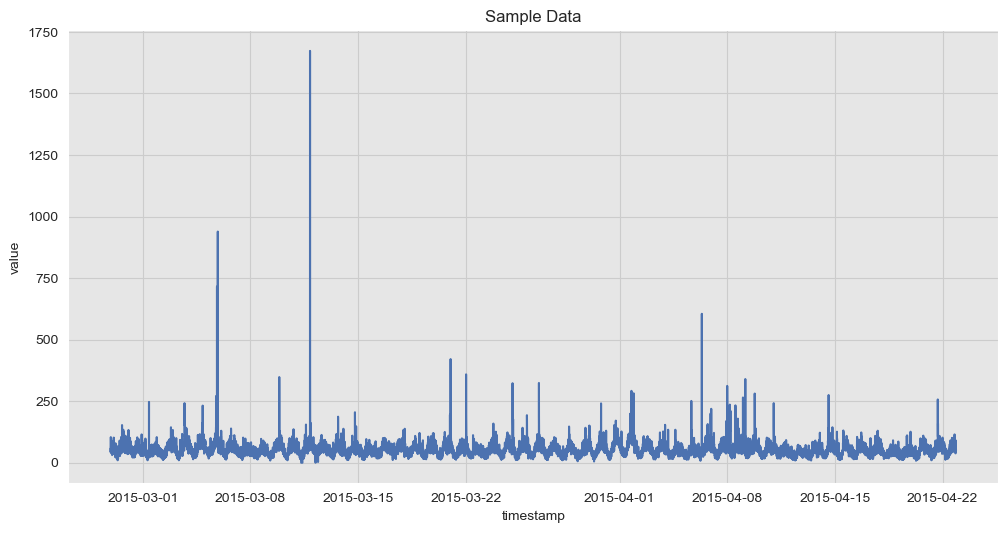

In [5]:
# Plot
fig, ax = plt.subplots()
sns.lineplot(x='timestamp', y='value', data=df, ax=ax)
ax.set(title='Sample Data');

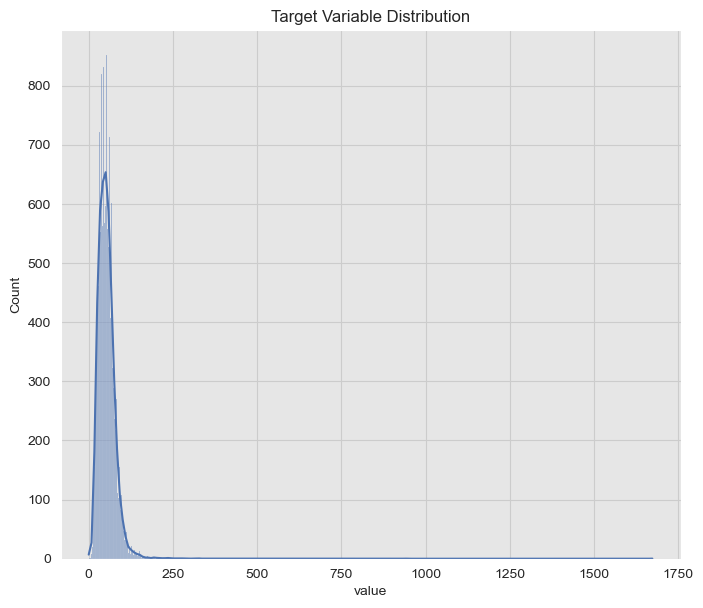

In [6]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.histplot(x='value', data=df, color=sns_c[0], kde=True, ax=ax)
ax.set(title='Target Variable Distribution');

We see that all values are non-negative.

In [7]:
df.query('value < 0').shape[0]

0

<AxesSubplot:xlabel='value', ylabel='Count'>

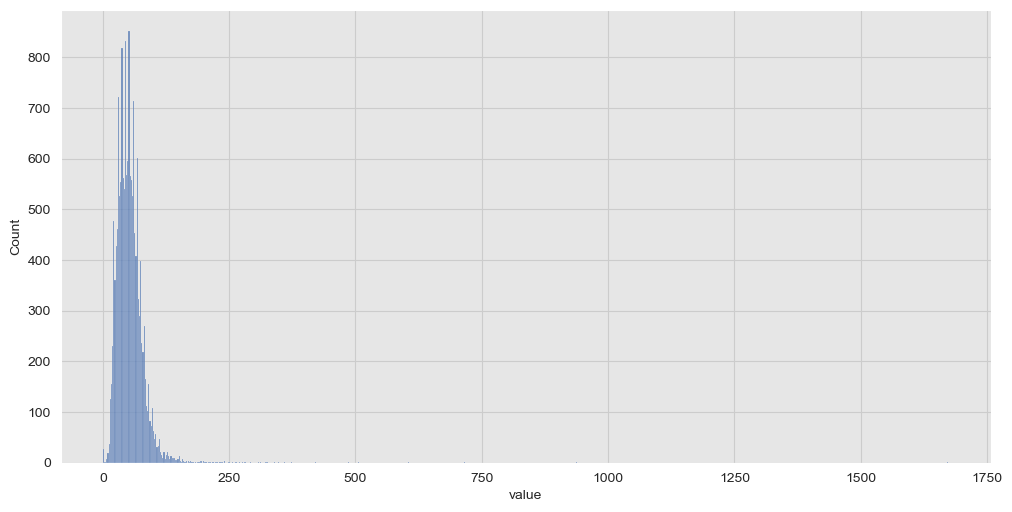

In [20]:
fig, ax = plt.subplots()
sns.histplot(x=df['value'], ax=ax)

## Define Dataset

In [8]:
train_test_split = '2015-04-05 00:02:53'
df_train = df.query(f'timestamp < "{train_test_split}"')
df_test = df.query(f'timestamp >= "{train_test_split}"')
# The only requirements for a custom dataset are to be iterable and have a “target” and a “start” field
# Train
params_train = {
    'start': df_train.iloc[0]['timestamp'], 
    'target': df_train['value']
}
data_train = common.ListDataset([params_train], freq='5min')
# Test
params_test = {
    'start': df_test.iloc[0]['timestamp'], 
    'target': df_test['value']
}
data_test = common.ListDataset([params_test], freq='5min')

## Train Model

**From the source code:**

Bases: gluonts.model.estimator.GluonEstimator

Construct a DeepAR estimator.

*This implements an RNN-based model, close to the one described in [SFG17].*

*Note: the code of this model is unrelated to the implementation behind SageMaker’s DeepAR Forecasting Algorithm.*

    Parameters
    freq – Frequency of the data to train on and predict

    prediction_length – Length of the prediction horizon

    trainer – Trainer object to be used (default: Trainer())

    context_length – Number of steps to unroll the RNN for before computing predictions (default: None, in which case context_length = prediction_length)

    num_layers – Number of RNN layers (default: 2)

    num_cells – Number of RNN cells for each layer (default: 40)

    cell_type – Type of recurrent cells to use (available: ‘lstm’ or ‘gru’; default: ‘lstm’)

    dropout_rate – Dropout regularization parameter (default: 0.1)

    use_feat_dynamic_real – Whether to use the feat_dynamic_real field from the data (default: False)

    use_feat_static_cat – Whether to use the feat_static_cat field from the data (default: False)

    use_feat_static_real – Whether to use the feat_static_real field from the data (default: False)

    cardinality – Number of values of each categorical feature. This must be set if use_feat_static_cat == True (default: None)

    embedding_dimension – Dimension of the embeddings for categorical features (default: [min(50, (cat+1)//2) for cat in cardinality])

    distr_output – Distribution to use to evaluate observations and sample predictions (default: StudentTOutput())

    scaling – Whether to automatically scale the target values (default: true)

    lags_seq – Indices of the lagged target values to use as inputs of the RNN (default: None, in which case these are automatically determined based on freq)

    time_features – Time features to use as inputs of the RNN (default: None, in which case these are automatically determined based on freq)

    num_parallel_samples – Number of evaluation samples per time series to increase parallelism during inference. This is a model optimization that does not affect the accuracy (default: 100)

## Generate Predictions

In [9]:
trainer = Trainer(epochs=10)
freq = '5min'
prediction_length = 12
estimator = deepar.DeepAREstimator(
    freq=freq, 
    prediction_length=prediction_length, 
    trainer=trainer
)

predictor = estimator.train(training_data=data_train)

100%|██████████| 50/50 [00:05<00:00,  9.93it/s, epoch=10/10, avg_epoch_loss=3.95]


In [10]:
prediction = next(predictor.predict(data_train, num_samples=500))
print(prediction.mean)

[51.0529   50.292664 46.130634 47.147736 44.904728 45.793995 44.775696
 44.61252  46.082935 45.21891  48.011505 46.303463]


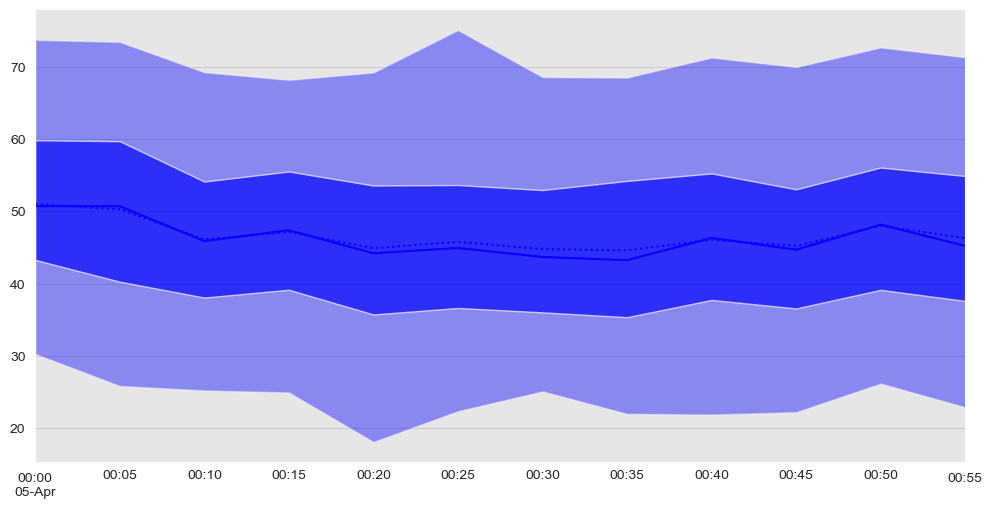

In [11]:
# We plot the predictions from one sample step:
prediction.plot(show_mean=True)

In [12]:
# Get other sample.
prediction = next(predictor.predict(data_train))
print(prediction.mean)

[50.704525 50.87418  45.369328 44.916718 43.75555  45.89068  44.277794
 41.09016  44.30301  43.78707  46.881607 44.417023]


## Model Evaluation

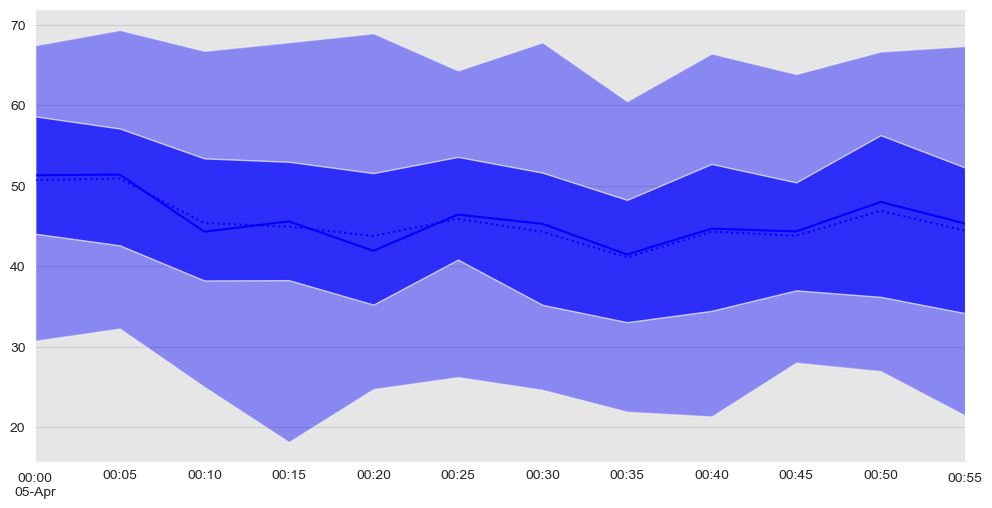

In [13]:
prediction.plot(show_mean=True)

Let us not generate many samples:

In [14]:
samples_list = []

for i in range(100):
    samples_list.append(
        list(predictor.predict(data_train, num_samples=200))[0].samples
    )

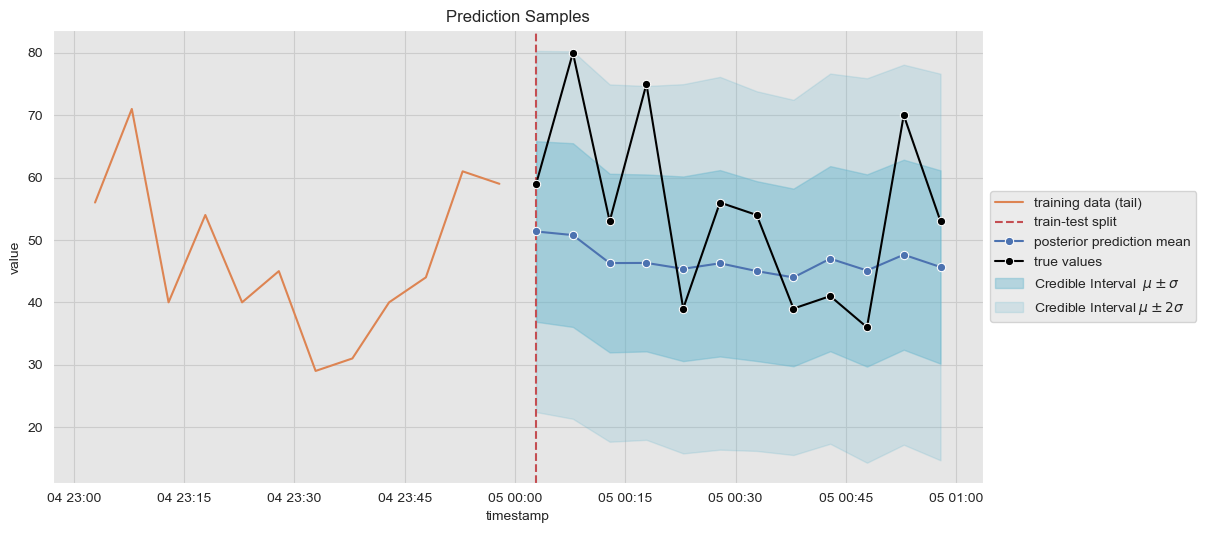

In [16]:
# Plot
xrange = pd.date_range(start=train_test_split, freq=freq, periods=prediction_length)
prediction_samples_mean = prediction_samples.mean(axis=0)
prediction_samples_std = prediction_samples.std(axis=0)
prediction_samples_mean_plus = prediction_samples_mean + prediction_samples_std 
prediction_samples_mean_minus = prediction_samples_mean - prediction_samples_std 
prediction_samples_mean_2plus = prediction_samples_mean + 2*prediction_samples_std 
prediction_samples_mean_2minus = prediction_samples_mean - 2*prediction_samples_std 

fig, ax = plt.subplots() 
# Tarining data (tail)
sns.lineplot(
    x='timestamp', 
    y='value', 
    data= df.query(f'timestamp < "{train_test_split}"').tail(12),
    color=sns_c[1],
    label='training data (tail)',
    ax=ax
)
# Training-Test split.
ax.axvline(x=train_test_split, color=sns_c[3], linestyle='--', label='train-test split')
# Credible intervals.
ax.fill_between(
    x=xrange, 
    y1=prediction_samples_mean_minus , 
    y2=prediction_samples_mean_plus , 
    color=sns_c[9], 
    alpha = 0.4, 
    label='Credible Interval  $\mu \pm \sigma$'
)
ax.fill_between(
    x=xrange, 
    y1=prediction_samples_mean_2minus , 
    y2=prediction_samples_mean_2plus , 
    color=sns_c[9], 
    alpha = 0.2, 
    label='Credible Interval $\mu \pm 2\sigma$'
)
# Posterior prediction mean.
sns.lineplot(
    x=xrange, 
    y=prediction_samples_mean, 
    marker='o', 
    label='posterior prediction mean',
    ax=ax
)
# True values. 
sns.lineplot(
    x='timestamp', 
    y='value', 
    data=df.query('timestamp in @xrange'), 
    color='black', 
    marker='o', 
    label='true values',
    ax=ax
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Samples');

In [15]:
prediction_samples = np.concatenate(samples_list, axis=0)
prediction_samples.shape

(20000, 12)

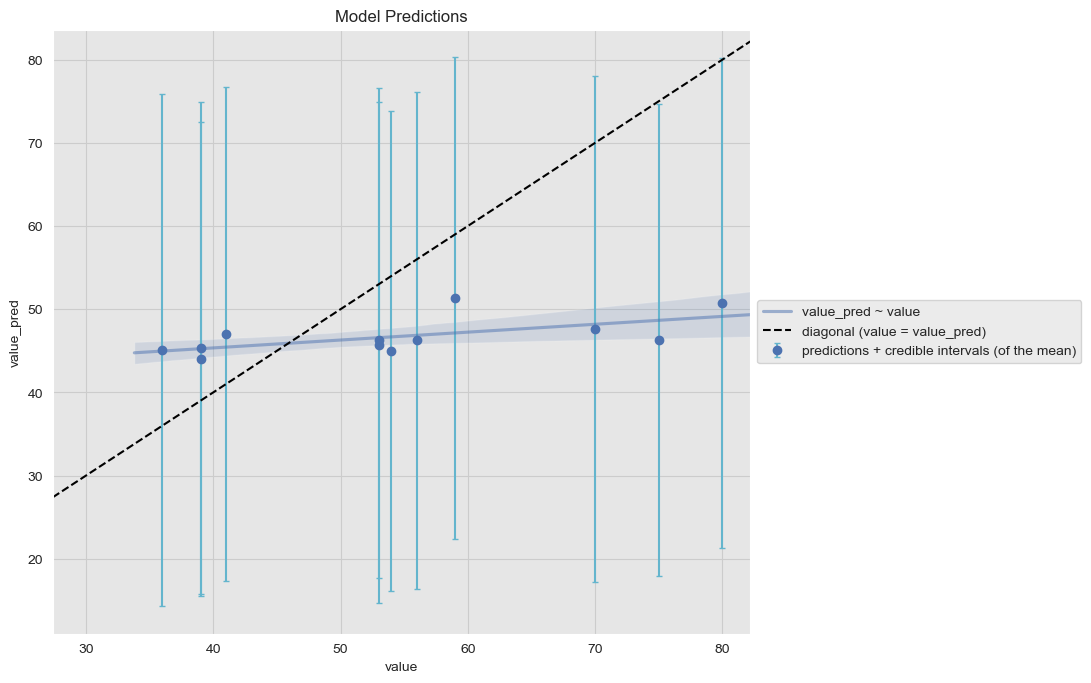

In [18]:
fig, ax = plt.subplots(figsize=(9, 8)) 
ax.errorbar(
    x=df.query('timestamp in @xrange')['value'], 
    y=prediction_samples_mean, 
    yerr=2*prediction_samples_std,
    fmt='o',
    ecolor=sns_c[9],
    capsize=2,
    label='predictions + credible intervals (of the mean)'
)
sns.regplot(
    x=df.query('timestamp in @xrange')['value'], 
    y=prediction_samples_mean, 
    color=sns_c[0], 
    scatter=False,
    line_kws=dict(alpha=0.5), 
    label='value_pred ~ value', 
    truncate=False,
    ax=ax
)
ax.axline(xy1=(30,30), slope=1, linestyle='--', color='black', label='diagonal (value = value_pred)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Model Predictions', xlabel='value', ylabel='value_pred');

We can also use `make_evaluation_predictions` to generate predictions.

In [19]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=data_test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(ts_it, forecast_it, num_series=len(data_test))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]WARNING:root:multiple 5 does not divide base seasonality 1.Falling back to seasonality 1



In [20]:
# Aggregated metrics.
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 245.56494140625,
    "abs_error": 166.36074829101562,
    "abs_target_sum": 676.0,
    "abs_target_mean": 56.333333333333336,
    "seasonal_error": 12.432411375146085,
    "MASE": 1.1151011073067125,
    "MAPE": 0.2540552065036889,
    "sMAPE": 0.23747474560415294,
    "OWA": NaN,
    "MSIS": 6.621304921236688,
    "QuantileLoss[0.1]": 42.53530197143555,
    "Coverage[0.1]": 0.16666666666666666,
    "QuantileLoss[0.5]": 166.36072540283203,
    "Coverage[0.5]": 0.75,
    "QuantileLoss[0.9]": 89.26747589111328,
    "Coverage[0.9]": 0.9166666666666666,
    "RMSE": 15.670511842510123,
    "NRMSE": 0.2781747664350909,
    "ND": 0.24609578149558525,
    "wQuantileLoss[0.1]": 0.06292204433644312,
    "wQuantileLoss[0.5]": 0.2460957476373255,
    "wQuantileLoss[0.9]": 0.1320524791288658,
    "mean_wQuantileLoss": 0.14702342370087815,
    "MAE_Coverage": 0.11111111111111109
}


In [21]:
# Metrics per time series. 
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,245.564941,166.360748,676.0,56.333333,12.432411,1.115101,0.254055,0.237475,NaN,6.621305,42.535302,0.166667,166.360725,0.75,89.267476,0.916667


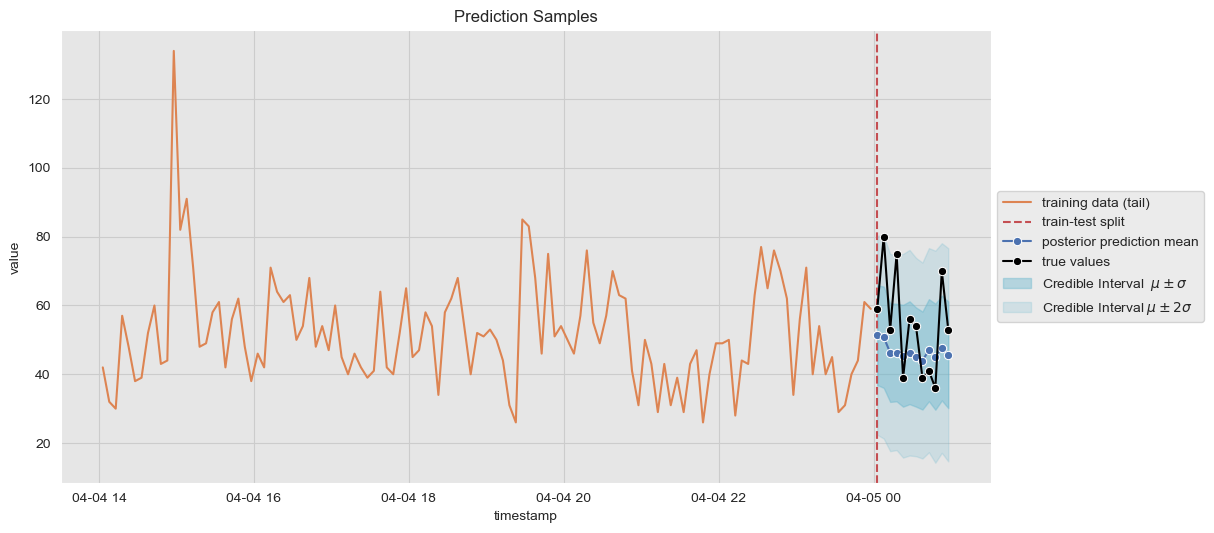

In [17]:
fig, ax = plt.subplots() 
# Tarining data (tail)
sns.lineplot(
    x='timestamp', 
    y='value', 
    data= df.query(f'timestamp < "{train_test_split}"').tail(120),
    color=sns_c[1],
    label='training data (tail)',
    ax=ax
)
# Training-Test split.
ax.axvline(x=train_test_split, color=sns_c[3], linestyle='--', label='train-test split')
# Credible intervals.
ax.fill_between(
    x=xrange, 
    y1=prediction_samples_mean_minus , 
    y2=prediction_samples_mean_plus , 
    color=sns_c[9], 
    alpha = 0.4, 
    label='Credible Interval  $\mu \pm \sigma$'
)
ax.fill_between(
    x=xrange, 
    y1=prediction_samples_mean_2minus , 
    y2=prediction_samples_mean_2plus , 
    color=sns_c[9], 
    alpha = 0.2, 
    label='Credible Interval $\mu \pm 2\sigma$'
)
# Posterior prediction mean.
sns.lineplot(
    x=xrange, 
    y=prediction_samples_mean, 
    marker='o', 
    label='posterior prediction mean',
    ax=ax
)
# True values. 
sns.lineplot(
    x='timestamp', 
    y='value', 
    data=df.query('timestamp in @xrange'), 
    color='black', 
    marker='o', 
    label='true values',
    ax=ax
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Samples');